# Mid_Term_클러스터링 분석

<i>201920948 신주현</i>

<b> 사용데이터</b> : 국세청_사업자현황_연령별_20240131 - 행정안전부_지역별.csv
<b>문제정의</b>: 본 분석을 통해 국내 농·임·어업 종사자 수를 확인해보고자 하며 '농·임·어업 종사자 수'는 '시도(지역)'중 강원도/경기도/전라도/경상도에 집중되어 분포할 것으로 예상.



### 0. 개발환경 구축

In [ ]:
# seaborn 설치
!pip3 install seaborn

In [1]:
# 데이터 시각화, 데이터 조작, 클러스터링, 전처리를 위한 라이브러리 import
import matplotlib.pyplot as plt 
import pandas as pd
import chardet
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

### 1. 한국어 지원 폰트 설정 (Skip)
- matplotlib 결과값 한글 미지원으로 인해 추가
- GitHub Codespace 내 사용 불가

In [ ]:
import matplotlib.font_manager as fm

# 시스템에 설치된 폰트 리스트 로딩
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')

# 한국어를 지원하는 폰트 이름을 검색 (예: 'Nanum', 'Malgun' 등)
korean_font_name = None
for font in font_list:
    if 'Nanum' in font or 'Malgun' in font:  # 'Nanum', 'Malgun' 등 한국어 폰트 이름 포함 여부 확인
        korean_font_name = fm.FontProperties(fname=font).get_name()
        break

if korean_font_name:
    # 한국어 폰트를 찾았다면, Matplotlib의 기본 폰트로 설정
    plt.rcParams['font.family'] = korean_font_name
    print(f"Found Korean font: {korean_font_name}")
else:
    print("Korean font not found. Please install a Korean font.")


### 2. 파일 읽어오기

In [2]:
# 파일 인코딩 감지
with open('국세청_사업자현황_연령별_20240131 - 행정안전부_지역별.csv', 'rb') as file:
    result = chardet.detect(file.read())  # 파일의 내용에 따라 인코딩 감지

# csv데이터 읽어오기
df = pd.read_csv("국세청_사업자현황_연령별_20240131 - 행정안전부_지역별.csv", encoding=result['encoding'])

### 3. 전체 데이터 구조 파악

In [3]:
# 데이터의 처음 몇 줄을 출력하여 데이터 구조 파악
print("데이터 미리보기:")
print(df.head())

# 데이터 프레임의 행과 열의 수 출력
print("\n데이터의 행과 열의 수:")
print(df.shape)

# 각 열의 데이터 타입 출력
print("\n각 열의 데이터 타입:")
print(df.dtypes)

# 각 열의 결측치 수 계산
print("\n각 열의 결측치 수:")
print(df.isnull().sum())

# 기본적인 통계 정보 출력
print("\n기본적인 통계 정보:")
print(df.describe())

# 각 열의 고유값 개수 출력
print("\n각 열의 고유값 개수:")
print(df.nunique())

데이터 미리보기:
      업태별     시도  시군구     연령별  (전체)당월  (전체)전월  (전체)전년동월  (개인)당월  (개인)전월  \
0  농·임·어업  서울특별시  종로구  30세 미만       0       0         0       0       0   
1  농·임·어업  서울특별시  종로구  30세 이상       3       3         3       0       0   
2  농·임·어업  서울특별시  종로구  40세 이상       0       0         0       0       0   
3  농·임·어업  서울특별시  종로구  50세 이상       5       5         4       0       0   
4  농·임·어업  서울특별시  종로구  60세 이상       8       8        10       0       0   

   (개인)전년동월  (법인)당월  (법인)전월  (법인)전년동월  
0         0       0       0         0  
1         0       0       0         0  
2         0       0       0         0  
3         0       3       3         0  
4         0       6       6         6  

데이터의 행과 열의 수:
(21732, 13)

각 열의 데이터 타입:
업태별         object
시도          object
시군구         object
연령별         object
(전체)당월       int64
(전체)전월       int64
(전체)전년동월     int64
(개인)당월       int64
(개인)전월       int64
(개인)전년동월     int64
(법인)당월       int64
(법인)전월       int64
(법인)전년동월     int64
dtype: obje

### 4. 데이터 전처리
- 전체 데이터 중 사용하지 않거나 편집이 필요한 데이터 병합

In [4]:
# 활용하지 않는 열 데이터 삭제
df = df.drop(['(전체)전년동월', '(개인)당월', '(개인)전월', '(개인)전년동월', '(법인)당월', '(법인)전월', '(법인)전년동월'], axis=1)

df = df[~df['업태별'].isin(['광업', '제조업', '전기·가스·수도업', '도매업', '소매업', '부동산매매업', '건설업', '음식업', '숙박업', '운수·창고·통신업', '부동산임대업', '대리·중개·도급업', '서비스업(기타포함)'])]

# 활용하지 않는 열 데이터 제외
df.drop(['시군구'], axis=1, inplace=True, errors='ignore')

### 5. 데이터 내 특정 행 병합 후 합계 확인
- 각 시도별 농·임·어업 사업자 전체 추산을 위해 나이대 병합후 출력

In [5]:
# '(전체)전월'의 데이터를 병합 후 합계를 구함
grouped_data = df.groupby('시도')['(전체)전월'].sum().reset_index()

# 결과 출력
print(grouped_data)

         시도  (전체)전월
0   강원특별자치도    8897
1       경기도   17101
2      경상남도   21072
3      경상북도   14542
4     광주광역시     530
5     대구광역시     953
6     대전광역시     594
7     부산광역시    1846
8     서울특별시     719
9   세종특별자치시     675
10    울산광역시    1276
11    인천광역시    2425
12     전라남도   20246
13  전북특별자치도    8917
14  제주특별자치도    5760
15     충청남도   13628
16     충청북도    5691


### 6. 전처리 데이터 시각화
- 각 시도별 농·임·어업 사업자 전체 추산 및 시각화

/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packag

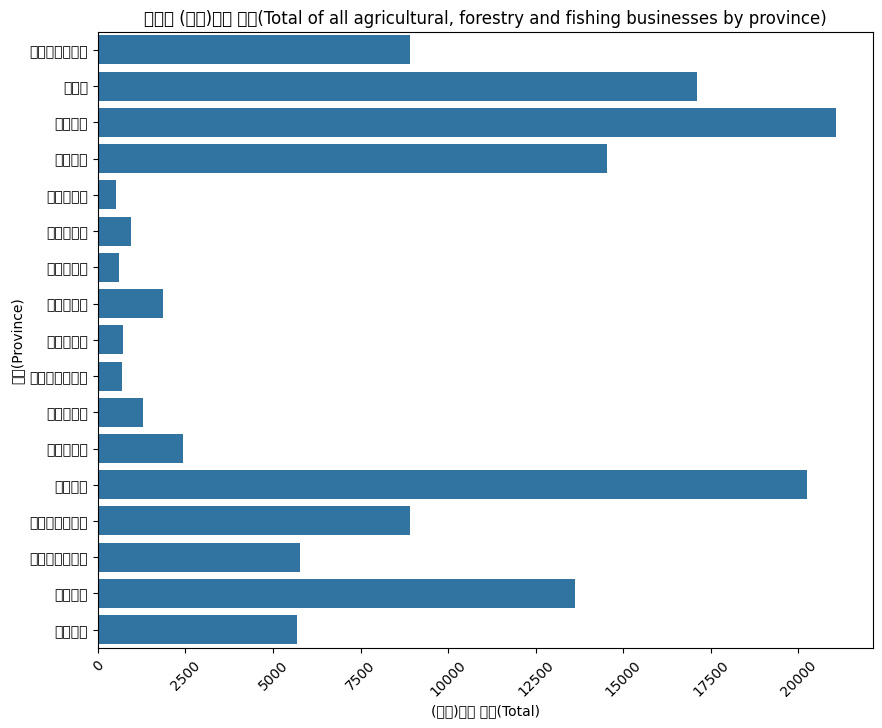

In [6]:
# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='(전체)전월', y='시도', data=grouped_data)  # seaborn의 barplot 함수를 사용하여 막대 그래프 생성

plt.title('시도별 (전체)전월 합계(Total of all agricultural, forestry and fishing businesses by province)')
plt.xlabel('(전체)전월 합계(Total)')
plt.ylabel('시도(Province)')
plt.xticks(rotation=45)  # 가독성 향상을 위해 x축 라벨의 각도를 45도 회전
plt.show()

### 7. K-means 클러스터링 실행
- 엘보우 방법으로 여러 k 값에 대한 클러스터링을 수행하고 WCSS값을 계산해 최적의 클러수터 수를 결정

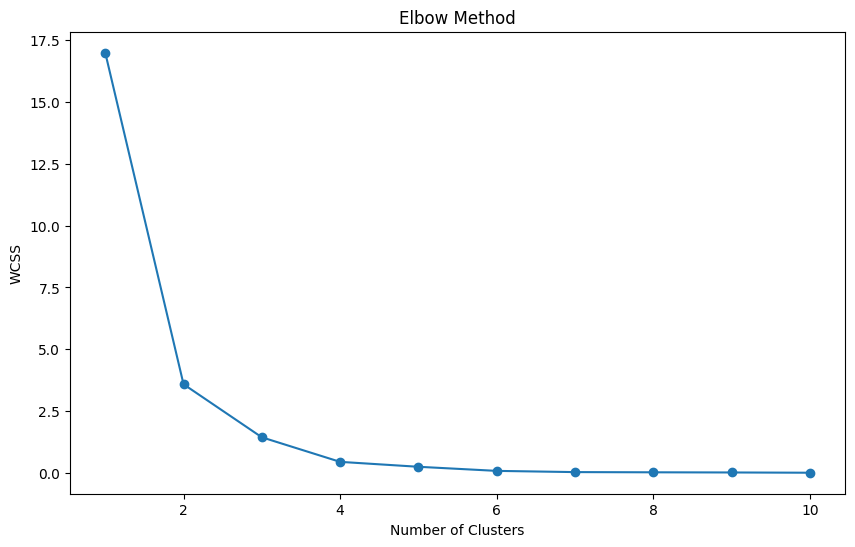

In [7]:
# 표준화 준비
scaler = StandardScaler()

# '시도'를 제외한 '(전체)전월' 데이터만 추출하여 표준화 진행
data_scaled = scaler.fit_transform(grouped_data[['(전체)전월']])

# 최적의 클러스터 수를 찾기 위해 elbow 방법 사용
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

# elbow 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

### 8. 최적의 클러스터 수 결정
- k가 6 이후부터 변화가 거의 없어 보이므로 클러스터 수(k)는 6이 적절해 보임

/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/I

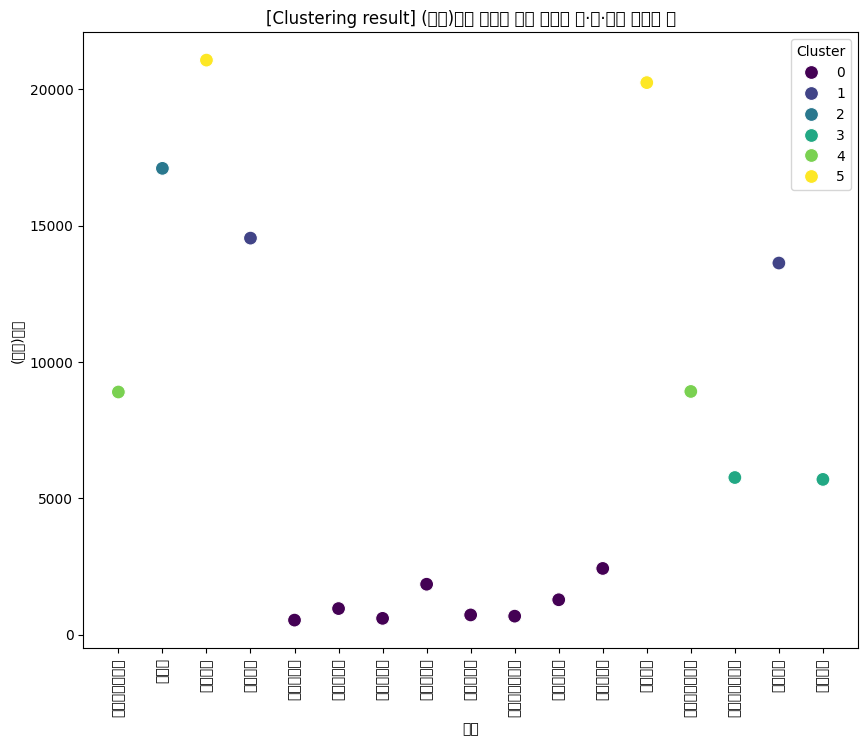

In [8]:
# 최적의 클러스터 수를 정한 후 클러스터링 진행
# Cluster Number가 6 이후 변동이 적으므로 6을 최적의 클러스터 수로 설정
optimal_clusters = 6
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(data_scaled)

# 클러스터 레이블을 원본 데이터프레임에 추가
grouped_data['Cluster'] = cluster_labels

# 클러스터별 시각화
plt.figure(figsize=(10, 8))
sns.scatterplot(x='시도', y='(전체)전월', hue='Cluster', data=grouped_data, palette='viridis', s=100)
plt.title('[Clustering result] (전체)전월 합계에 따른 시도별 농·임·어업 종사자 수')
plt.xticks(rotation=90)  # 가독성을 위해 '시도' 라벨 회전
plt.show()

### 9. 중심점 분석 및 산점도 시각화

클러스터 중심점 (원본 스케일):
클러스터 0: (전체)전월 = 1127.25
클러스터 1: (전체)전월 = 14085.00
클러스터 2: (전체)전월 = 17101.00
클러스터 3: (전체)전월 = 5725.50
클러스터 4: (전체)전월 = 8907.00
클러스터 5: (전체)전월 = 20659.00


/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/I

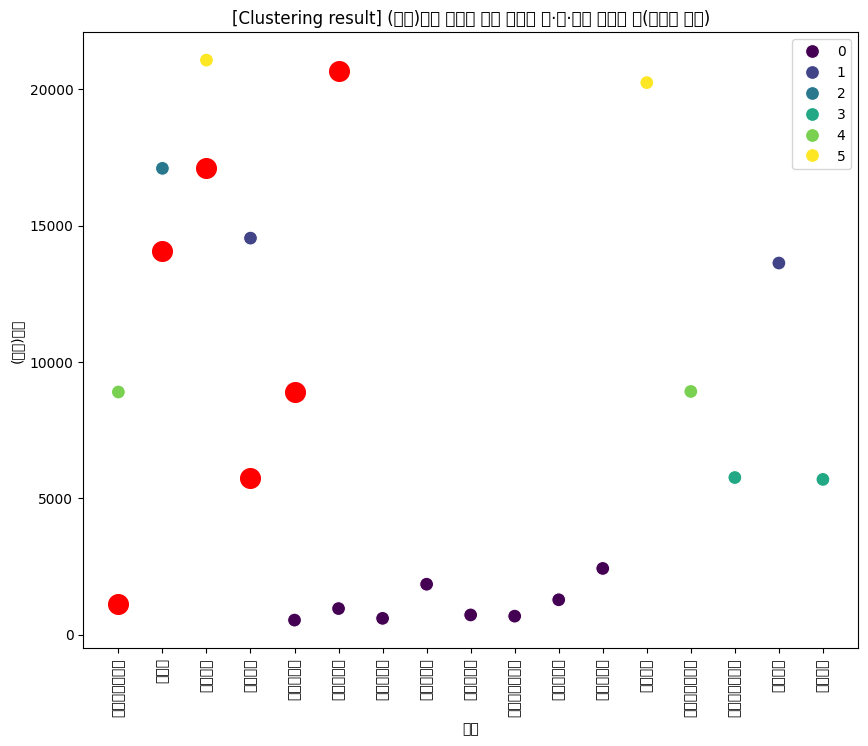

In [9]:
# 중심점 분석
centers = kmeans.cluster_centers_

# 중심점을 원본 스케일로 변환
centers_original_scale = scaler.inverse_transform(centers)

# 중심점 출력
print("클러스터 중심점 (원본 스케일):")
for i, center in enumerate(centers_original_scale):
    print(f"클러스터 {i}: (전체)전월 = {center[0]:.2f}")

# 클러스터와 중심점 시각화
plt.figure(figsize=(10, 8))
sns.scatterplot(x='시도', y='(전체)전월', hue='Cluster', data=grouped_data, palette='viridis', s=100, legend='full')

# 중심점을 빨간색으로 산점도에 추가
for i, center in enumerate(centers_original_scale):
    plt.scatter(i, center[0], color='red', s=200)  # x축은 클러스터 번호, y축은 중심점의 값

plt.legend()
plt.title('[Clustering result] (전체)전월 합계에 따른 시도별 농·임·어업 종사자 수(중심점 추가)')
plt.xticks(rotation=90)
plt.show()


### 10. 실루엣 점수 계산

In [10]:
# 실루엣 점수 계산
silhouette_avg = silhouette_score(data_scaled, cluster_labels)
print(f"실루엣 점수: {silhouette_avg:.3f}")

실루엣 점수: 0.788


### 11. 평가
실루엣 점수: 0.788181

(-1)~(1)까지의 값 중 실루엣 점수의 분포에 따라 다음과 같이 구분됨
- 1 근접 : 다른 군집과 잘 분리된 군집
- 0 근접 : 근처의 군집과 경계가 모호한 군집
- -1 근접 : 잘못 분류된 군집


'시도별 위치'와 '농·임·어업 사업자 수'에 대한 데이터는 실루엣 점수가 0.78로 서로 유의미한 관계를 가지며 각각의 군집이 서로 잘 분리된 관계임을 알 수 있음.